In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [5]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 50
num_patches_to_use = onp.array([2, 8, 32, 128, 512, 2048, 8192, 32768])
# num_patches_to_use = onp.array([2, 8, 32, 128, 512, 2048, 8192])
num_patches = num_patches_to_use.max()
num_test_set_patches = 4000
num_images = num_patches
num_bootstraps = 10
# channel = 'DPC_Right'
channel = 'LED119'
eigenvalue_floor = 1e-5

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = {}
cov_mats_pd = {}
non_stationary_means = {}
stationary_means = {}
cov_mats_stationary = {}
cov_mats_stationary_pd = {}
for n_patches in tqdm(num_patches_to_use):
    cov_mats[n_patches] = []
    cov_mats_pd[n_patches] = []
    non_stationary_means[n_patches] = []
    stationary_means[n_patches] = []
    cov_mats_stationary[n_patches] = []
    cov_mats_stationary_pd[n_patches] = []
    for i in range(num_bootstraps):
        patch_indices = onp.random.choice(np.arange(patches.shape[0]), n_patches, replace=False)
        bootstrapped_patches = patches[patch_indices]
        cov_mat = compute_cov_mat(bootstrapped_patches)
        cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor, show_plot=False)
        non_stationary_mean = np.mean(bootstrapped_patches, axis=0).flatten()
        stationary_mean = non_stationary_mean * np.ones_like(non_stationary_mean)
        cov_mat_stationary = compute_stationary_cov_mat(bootstrapped_patches)
        cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=eigenvalue_floor, show_plot=False)

        cov_mats[n_patches].append(cov_mat)
        cov_mats_pd[n_patches].append(cov_mat_pd)
        non_stationary_means[n_patches].append(non_stationary_mean)
        stationary_means[n_patches].append(stationary_mean)
        cov_mats_stationary[n_patches].append(cov_mat_stationary)
        cov_mats_stationary_pd[n_patches].append(cov_mat_stationary_pd)

100%|██████████| 8/8 [14:23<00:00, 107.90s/it]


Text(0.5, 0.98, 'Eigenvalues of stationary and non-stationary covariance matrices vs dataset size (50x50 patches)')

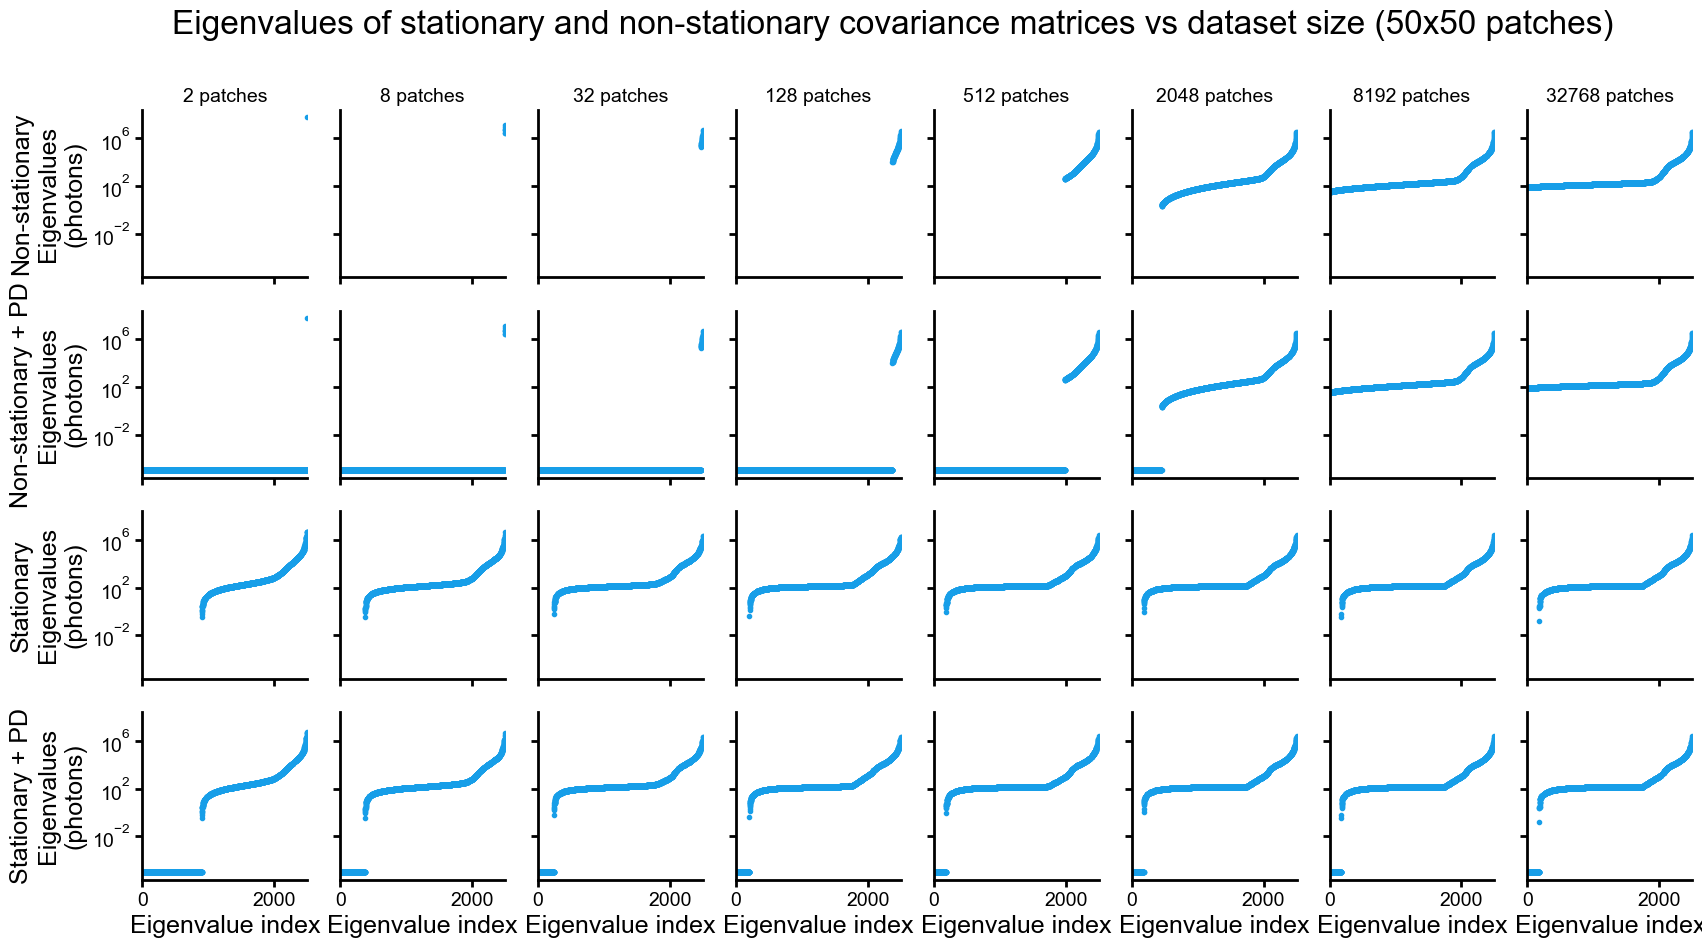

In [6]:
fig, ax = plt.subplots(4, num_patches_to_use.shape[0], figsize=(num_patches_to_use.shape[0] * 2.5, 10), sharex=True, sharey=True)

for i, n_patches in enumerate(num_patches_to_use):
    eigs = np.linalg.eigvalsh(cov_mats[n_patches][0])
    eigs_pd = np.linalg.eigvalsh(cov_mats_pd[n_patches][0])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[n_patches][0])
    eigs_stationary_pd = np.linalg.eigvalsh(cov_mats_stationary_pd[n_patches][0])
    ax[0, i].semilogy(eigs, '.')
    ax[1, i].semilogy(eigs_pd, '.')
    ax[2, i].semilogy(eigs_stationary, '.')
    ax[3, i].semilogy(eigs_stationary_pd, '.')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    clear_spines(ax[3, i])

    ax[0, i].set_title(f'{n_patches} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Non-stationary + PD\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[3, i].set_ylabel('Stationary + PD\nEigenvalues\n(photons)')
    ax[-1, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size ({}x{} patches)'.format(patch_size, patch_size))

### Compute likelihood on held out test set

In [7]:
confidence_interval = 90

test_data = test_set_patches.reshape(test_set_patches.shape[0], -1)
# compute log likelihood of test set
log_likelihoods_full_mean = []
log_likelihoods_full_confidence_interval = []
log_likelihoods_stationary_mean = []
log_likelihoods_stationary_confidence_interval = []
for n_patches in tqdm(num_patches_to_use):
    non_stationary_results = []
    stationary_results = []
    for bootstrap_i in range(num_bootstraps):
        cov_mat_pd = cov_mats_pd[n_patches][bootstrap_i]
        cov_mat_stationary_pd = cov_mats_stationary_pd[n_patches][bootstrap_i]
        non_stationary_mean = non_stationary_means[n_patches][bootstrap_i]
        stationary_mean = stationary_means[n_patches][bootstrap_i]
        non_stationary_results.append(jax.scipy.stats.multivariate_normal.logpdf(test_data, mean=non_stationary_mean, cov=cov_mat_pd))
        stationary_results.append(jax.scipy.stats.multivariate_normal.logpdf(test_data, mean=stationary_mean, cov=cov_mat_stationary_pd))
    non_stationary_results = np.array(non_stationary_results)
    stationary_results = np.array(stationary_results)
    log_likelihoods_full_mean.append(non_stationary_results.mean())
    log_likelihoods_full_confidence_interval.append([np.percentile(non_stationary_results, (100 - confidence_interval) / 2),
                                                        np.percentile(non_stationary_results, 100 - (100 - confidence_interval) / 2)])
    log_likelihoods_stationary_mean.append(stationary_results.mean())
    log_likelihoods_stationary_confidence_interval.append([np.percentile(stationary_results, (100 - confidence_interval) / 2),
                                                        np.percentile(stationary_results, 100 - (100 - confidence_interval) / 2)])

log_likelihoods_full_mean = np.array(log_likelihoods_full_mean)
log_likelihoods_full_confidence_interval = np.array(log_likelihoods_full_confidence_interval)
log_likelihoods_stationary_mean = np.array(log_likelihoods_stationary_mean)
log_likelihoods_stationary_confidence_interval = np.array(log_likelihoods_stationary_confidence_interval)


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


Text(0.5, 0.98, 'Log likelihood of test set vs train set size (50x50 patches)')

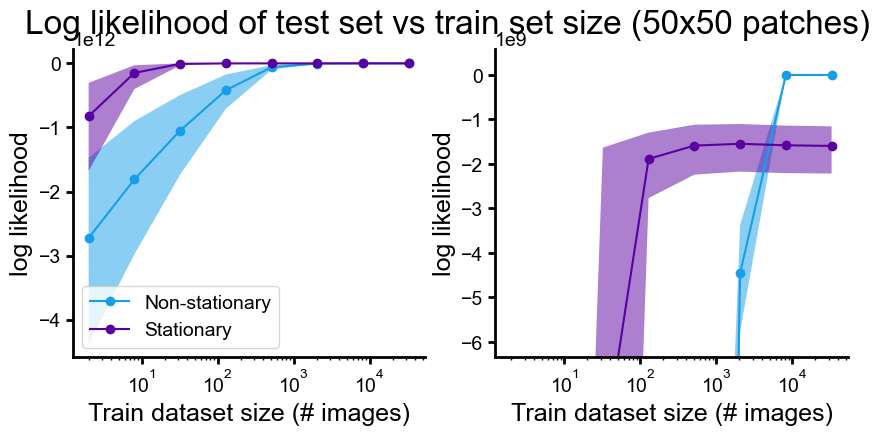

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot the log likelihoods of both on the same plot
ax[0].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[0].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[0].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[0].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[0].set(xlabel='Train dataset size (# images)', ylabel='log likelihood')
ax[0].legend()
clear_spines(ax[0])

# zoom in on the top right 
ax[1].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[1].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[1].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[1].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[1].set(xlabel='Train dataset size (# images)', ylabel='log likelihood')
# ax[1].legend()
clear_spines(ax[1])
# take the min and max of both plus a little extra to compute ylim
ylim_max = np.max(np.concatenate([log_likelihoods_full_confidence_interval[-3:], log_likelihoods_stationary_confidence_interval[-3:]])) 
ylim_min = np.min(np.concatenate([log_likelihoods_full_confidence_interval[-3:], log_likelihoods_stationary_confidence_interval[-3:]])) 
# ylim_min = - 6e3
# ylim_max = - 5e2
the_range = ylim_max - ylim_min
ax[1].set_ylim([ylim_min - 0.1 * the_range, ylim_max + 0.1 * the_range])
# make this one y labels in scientific notation also
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig.suptitle('Log likelihood of test set vs train set size ({}x{} patches)'.format(patch_size, patch_size))


# TODO: does increasing EV floor give higher Likelihood?

### Show samples from covariance matrices fit with different amounts of data

100%|█████████████████████████████████████████| 7/7 [00:00<00:00, 12.92it/s]
7it [00:00, 283.69it/s]


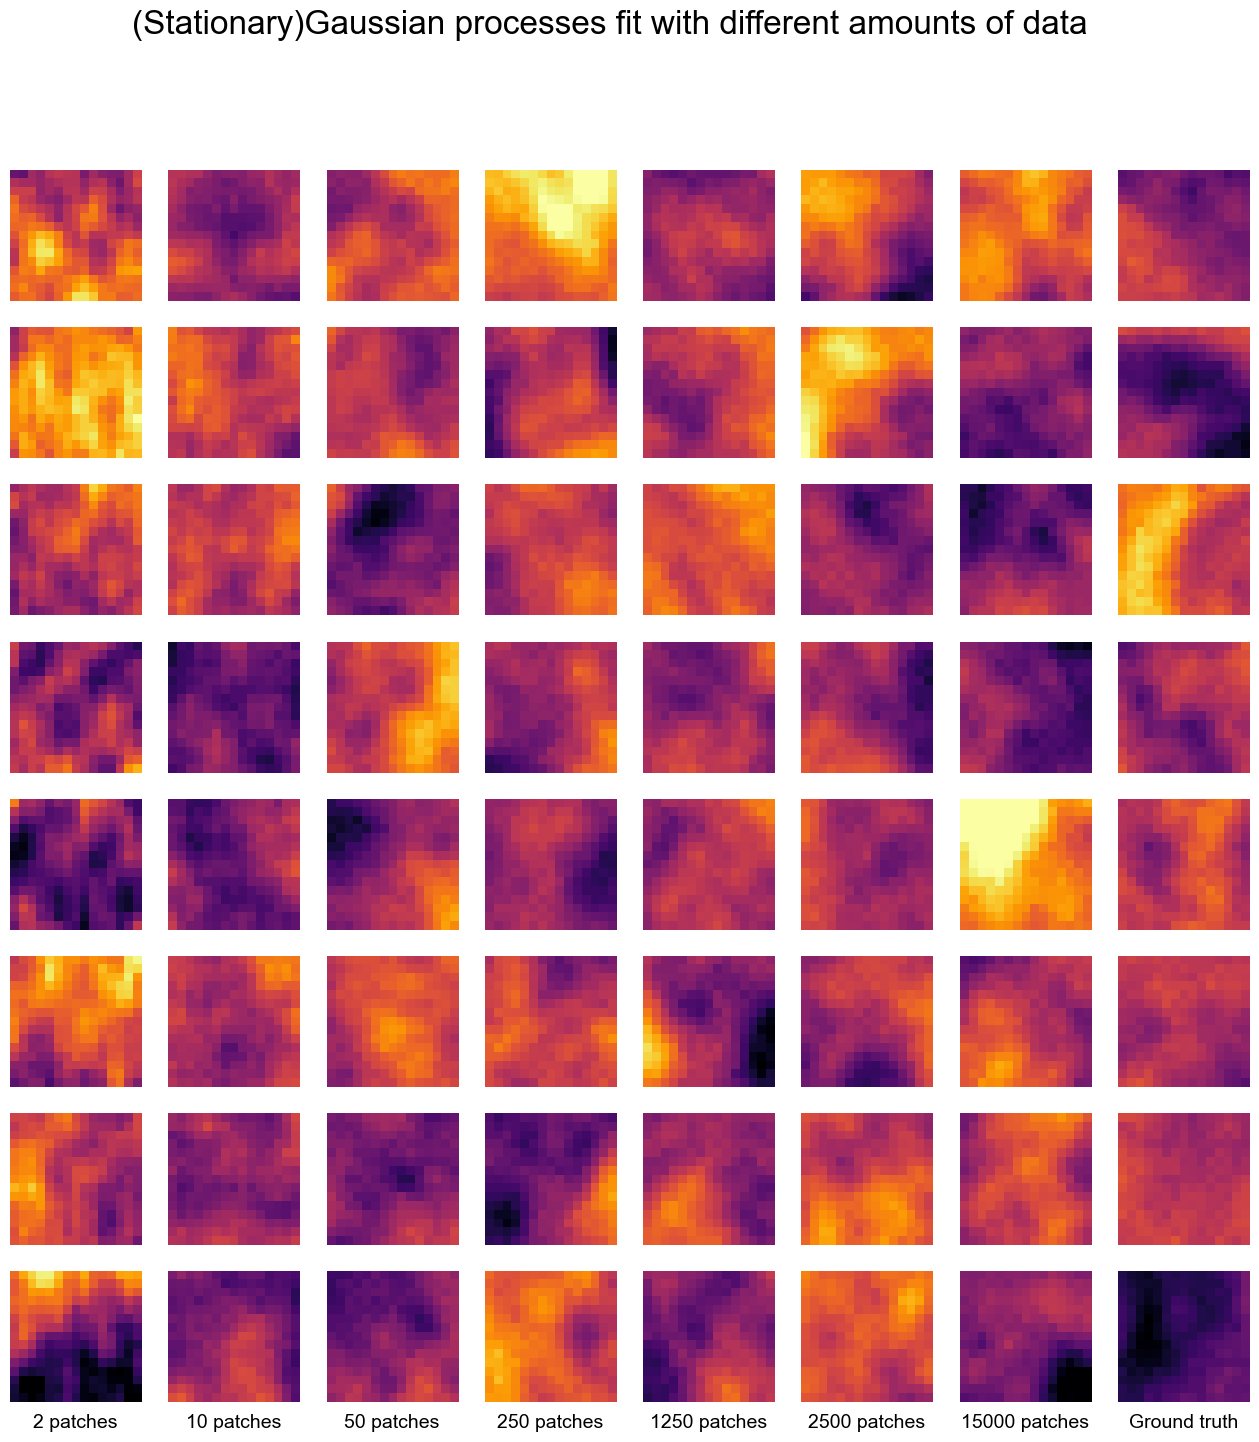

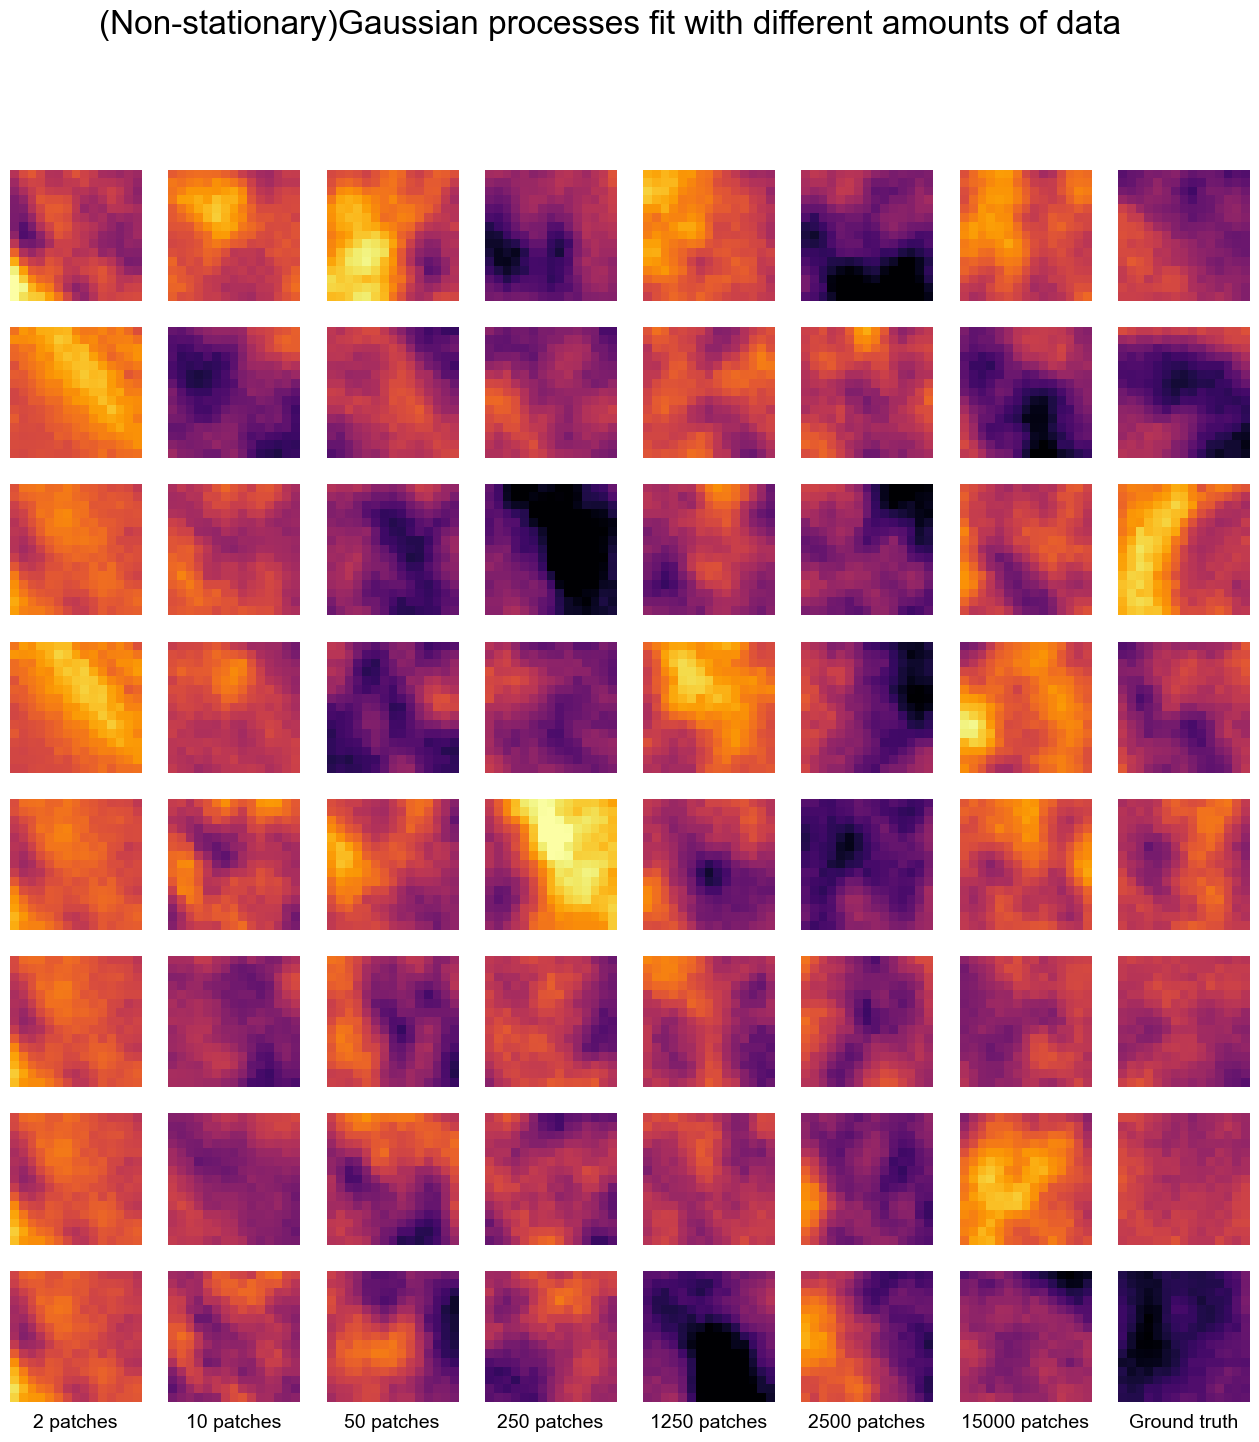

In [6]:
num_samples = 8
sample_size = patch_size

samples_stationary = []
for cov_mat in tqdm(cov_mats_stationary_pd):
    samples_stationary.append(generate_stationary_gaussian_process_samples(cov_mat, sample_size, num_samples, mean=np.mean(patches)))

samples_full = []
for cov_mat, mean in tqdm(zip(cov_mats_pd, non_stationary_means)):
    samples_full.append(generate_multivariate_gaussian_samples(cov_mat, num_samples, mean=mean))

for samples, prefix in zip([samples_stationary, samples_full], ['(Stationary)', '(Non-stationary)']):
    vmin, vmax = np.percentile(patches, 0.3), np.percentile(patches, 99.7)

    # plot samples
    fig, ax = plt.subplots(num_samples, len(cov_mats_pd) + 1, figsize=((len(cov_mats_pd) + 1) , num_samples ), sharex=True, sharey=True)

    for i in range(num_samples):
        for j in range(len(cov_mats_pd)):
            ax[i, j].imshow(samples[j][i], cmap='inferno', vmin=vmin, vmax=vmax)
            clear_spines(ax[i, j])
            if i == num_samples - 1:
                ax[i, j].text(0.5, -0.2, f'{num_patches_to_use[j]} patches', ha='center', transform=ax[i, j].transAxes)
            ax[i, j].axis('off')
        ax[i, -1].imshow(patches[5:][i], cmap='inferno', vmin=vmin, vmax=vmax)
        ax[i, -1].axis('off')
        if i == num_samples - 1:
            ax[i, -1].text(0.5, -0.2, f'Ground truth', ha='center', transform=ax[i, -1].transAxes)

    fig.suptitle(f'{prefix}Gaussian processes fit with different amounts of data')

## TODO: the bar chart for figure 2

In [18]:
# # create sample data
# channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
# experimental_data = [10, 20, 30]
# non_experimental_data = [15, 25, 35]

# # create a paired bar plot of results
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# colors = get_color_cycle()

# # set the width of the bars
# bar_width = 0.35

# # create the bar plots
# experimental_bars = ax.bar(np.arange(len(channel_names)), experimental_data, width=bar_width, color=colors[0], label='Experimental')
# non_experimental_bars = ax.bar(np.arange(len(channel_names)) + bar_width, non_experimental_data, width=bar_width, color=colors[1], label='Non-experimental')

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2)
# ax.set_xticklabels(channel_names)
# ax.set_ylabel('Data')
# ax.set_title('Experimental vs Non-experimental Data')
# ax.legend()

## TODO: Whats happening here??? Why does addin shot noise to experimental data not work?

In [19]:
# edge_crop = 24
# patch_size = 50
# channel = 'LED119'

# num_images = 10000
# num_patches = 10000

# photons_per_pixel = 150

# images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
# patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

# noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
# # noisy_patches = add_shot_noise(patches * photons_per_pixel / np.mean(images))
# estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, eigenvalue_floor=1, verbose=True)

# # cov_mat = compute_stationary_cov_mat(noisy_patches, verbose=True)
# # evs = np.linalg.eigvalsh(cov_mat)

# # # plot them
# # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# # ax.semilogy(evs)

## Information vs number of photons
Show all three channels and how they asumptote so collecting data at higher and higher SNR cant save you if encoding is bad
(i.e. sublinear returns on SNR)

In [20]:
edge_crop = 32
patch_size = 15

num_images = 10000
num_patches = 10000

photons_per_pixel_values = [10, 25, 50, 100, 200, 400, 800]

channel = 'DPC_Right'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

mi_means = []
mi_confidences = []

noisy_patches_for_display = []
for photons_per_pixel in tqdm(photons_per_pixel_values):
    # TODO: this doesnt work?
    # noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    noisy_patches_for_display.append(noisy_patches[:10])

mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)

Running bootstraps:   0%|                            | 0/50 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 9.87. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:   2%|▍                   | 1/50 [00:02<02:00,  2.46s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 9.88. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:   4%|▊                   | 2/50 [00:03<01:11,  1.48s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWa

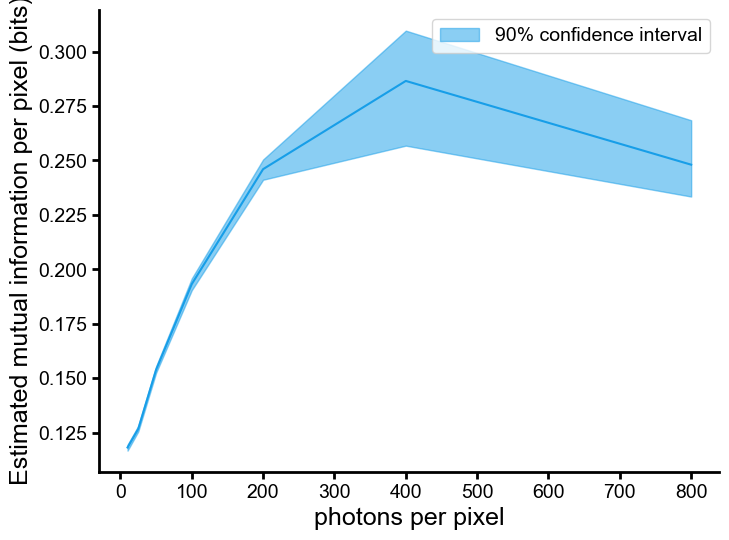

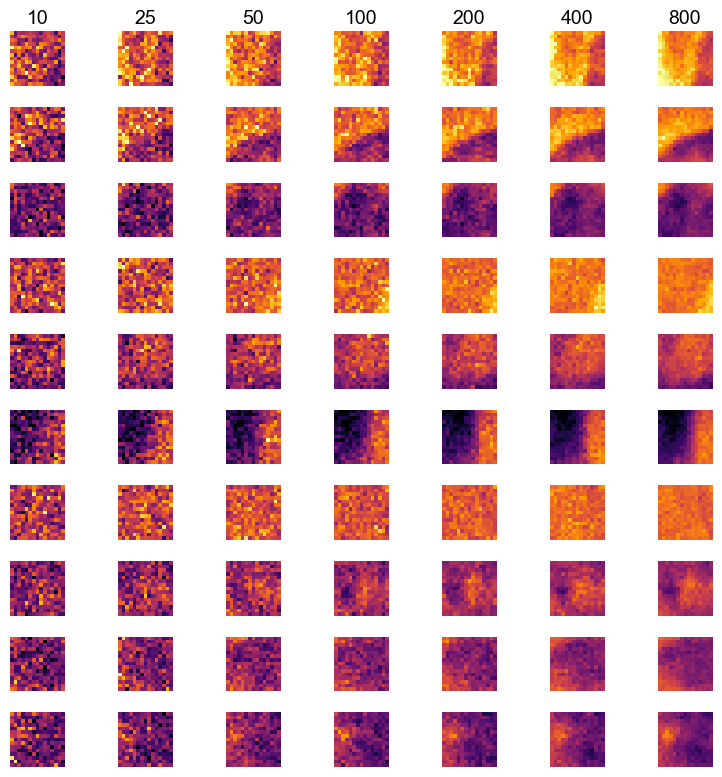

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], alpha=0.5, label='90% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()

fig, axs = plt.subplots(len(noisy_patches_for_display[0]), len(noisy_patches_for_display), figsize=(8, 8))
for i, noisy_patches in enumerate(noisy_patches_for_display):
    vmin, vmax = np.percentile(noisy_patches, 0.3), np.percentile(noisy_patches, 99.7)
    for j, patch in enumerate(noisy_patches):
        axs[j, i].imshow(patch, cmap='inferno', vmin=vmin, vmax=vmax)
        axs[j, i].axis('off')
        if i == 0:
            axs[j, i].set_ylabel(f'Patch {j+1}')
        if j == 0:
            axs[j, i].set_title(f'{photons_per_pixel_values[i]}')
plt.tight_layout()


# TODO mutual infor estimation at very low photon counts

## TODO: How do samples from GP approx look like with different patch sizes:
- starting from 1 pixel
- maybe this belongs in the other notebook